<a href="https://www.kaggle.com/code/chenggoo/titanic-prediction?scriptVersionId=93274184" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# load data
train_file = '/kaggle/input/titanic/train.csv'
test_file = '/kaggle/input/titanic/test.csv'
data_train = pd.read_csv(train_file, index_col='PassengerId')
data_test = pd.read_csv(test_file, index_col='PassengerId')


In [3]:
# Have a basic understanding of the table

data_train.info()
data_train.describe()
data_train.head()

# Next separate categorical columns from numerical columns;
# and notice the null data

cat_cols = ['Pclass', 'Sex', 'Cabin', 'Embarked', 'Ticket', 'Name']
num_cols = ['Age', 'SibSp', 'Parch', 'Fare']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Pclass


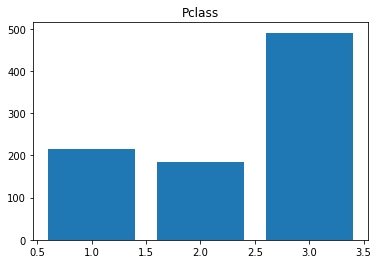

Sex


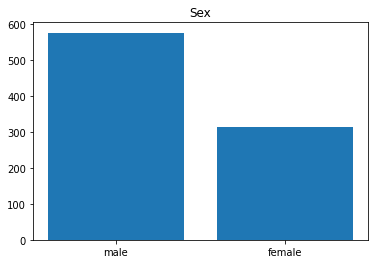

Cabin


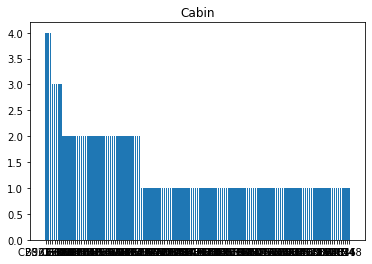

Embarked


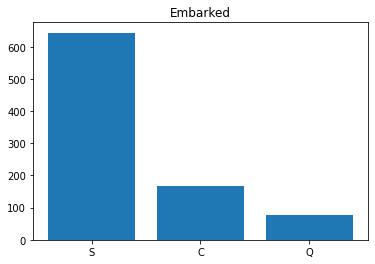

Ticket


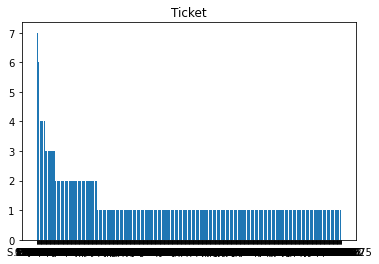

Name


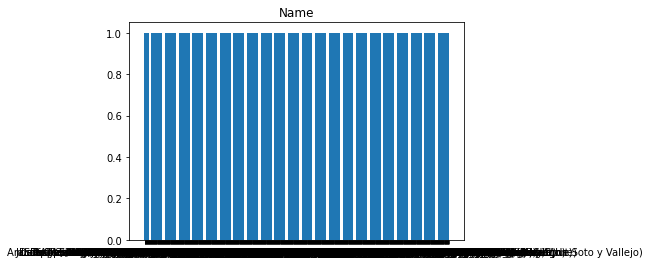

Age


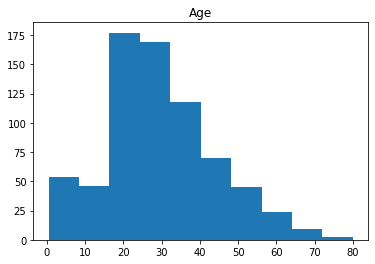

SibSp


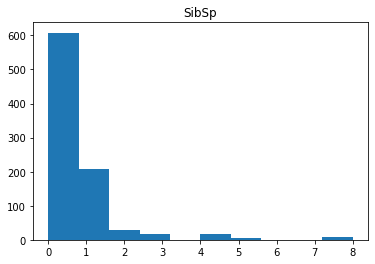

Parch


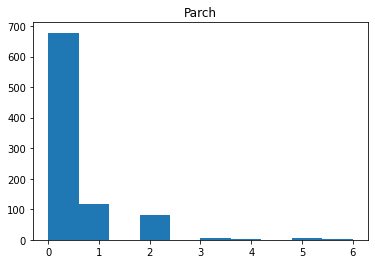

Fare


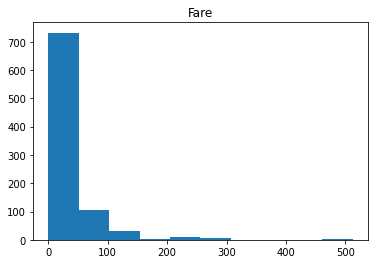

In [4]:
# Let us look at the feature distribution 

import matplotlib.pyplot as plt

for i in cat_cols:
    print(i)
    plt.bar(data_train[i].value_counts().keys(), data_train[i].value_counts())
    plt.title(i)
    plt.show()
    

for i in num_cols:
    print(i)
    plt.hist(data_train[i])
    plt.title(i)
    plt.show()

In [5]:
# get some feeling about the data
# how does Age, ticket fare (/Pclass), sex affect the survival rate?
age = pd.cut(data_train.Age, [0, 16, 50, 80])
pd.pivot_table(data_train, values='Survived', index=['Pclass', 'Sex'], columns=age, aggfunc=['mean', 'count'] )

# three factors all are important! Female, of the first class, childen are are likely to survive.

mean                       count                  
Age             (0, 16]  (16, 50]  (50, 80] (0, 16] (16, 50] (50, 80]
Pclass Sex                                                           
1      female  0.833333  0.969697  1.000000       6       66       13
       male    1.000000  0.444444  0.192308       3       72       26
2      female  1.000000  0.918033  0.666667      10       61        3
       male    0.818182  0.065789  0.083333      11       76       12
3      female  0.545455  0.411765  1.000000      33       68        1
       male    0.270270  0.135266  0.000000      37      207        9

In [6]:
# examine name title
title_unique = []
for i in range(891):
    title = data_train.Name.iloc[i].split(', ')[1].split('.')[0]
    if title not in title_unique:
        title_unique.append(title)
        
# name title
data_train['name_title'] = data_train.Name.apply(lambda x: x.split(', ')[1].split('.')[0])

# influence of name_title
pd.pivot_table(data_train, values='Name', columns='Survived', index='name_title', aggfunc='count' )

"notice the difference in survival rate between Miss and Mrs -- other categories might be just noise..."

'notice the difference in survival rate between Miss and Mrs -- other categories might be just noise...'

In [7]:
# analyze Cabin
data_train.Cabin.isnull().sum()
data_train['cabin_letter'] = data_train.Cabin.apply(lambda x: x[0] if not pd.isna(x) else '0')
data_train['cabin_length'] = data_train.Cabin.apply(lambda x: len(x) if not pd.isna(x) else 0)

In [8]:
pd.pivot_table(data_train, values='Ticket', columns='cabin_letter', index='Survived', aggfunc='count')
pd.pivot_table(data_train, values='Ticket', columns=['Sex', 'cabin_length'], index='Survived', aggfunc='count')

Sex          female                                              male       \
cabin_length     0    1     2     3     4    5    7    11   15     0    1    
Survived                                                                     
0              75.0  NaN   2.0   2.0   NaN  NaN  2.0  NaN  NaN  406.0  2.0   
1             142.0  2.0  12.0  58.0  10.0  1.0  4.0  2.0  2.0   64.0  NaN   

Sex                                          
cabin_length   2     3    4    5    7    11  
Survived                                     
0             5.0  39.0  8.0  3.0  2.0  3.0  
1             5.0  29.0  6.0  NaN  4.0  1.0

In [9]:
# Ticket

data_train['ticket_isnumeric'] = data_train.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
pd.pivot_table(data_train, values='Ticket', columns='Survived', index='ticket_isnumeric', aggfunc='count')
data_train['ticket_letter'] = data_train.Ticket.apply(lambda x: x.split(' ')[0].replace('.', '').replace('/', '').lower() if not x.isnumeric() else '0')

In [10]:
data_train['ticket_letter'].value_counts()
pd.pivot_table(data_train, values='Ticket', index='ticket_letter', columns='Survived', aggfunc='count')


Survived,0,1
ticket_letter,,
0,407.0,254.0
a4,7.0,NaN
a5,19.0,2.0
as,1.0,NaN
c,3.0,2.0
ca,27.0,14.0
casoton,1.0,NaN
fa,1.0,NaN
fc,1.0,NaN


In [11]:
# fill NA with constant value, specific to columns 
age_median = data_train.Age.median()
data_train['fare_log'] = np.log(data_train.Fare + 1)
fare_log_median = data_train.fare_log.median()

# deal with NA data
data_train['Embarked'] = data_train['Embarked'].fillna('C')



In [12]:
# let us write a function to do feature engineer for both training data and test data

def feature_engeering(data):
    # name title
    data['name_title'] = data.Name.apply(lambda x: x.split(', ')[1].split('.')[0])
    # get cabin_letter and length
    data['cabin_letter'] = data.Cabin.apply(lambda x: x[0] if not pd.isna(x) else '0')
    data['cabin_length'] = data.Cabin.apply(lambda x: len(x) if not pd.isna(x) else 0)
    # whether the ticket only contains numbers, and ticket letter not used as features
    data['ticket_isnumeric'] = data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
    data['ticket_letter'] = data.Ticket.apply(lambda x: x.split(' ')
        [0].replace('.', '').replace('/', '').lower() if not x.isnumeric() else '0')
    # take log of fare, making it more like normal distribution
    data['fare_log'] = np.log(data.Fare + 1)
    # deal with NA data, just two null data
    data['Embarked'] = data['Embarked'].fillna('C')
    return data



In [13]:
data_train = pd.read_csv(train_file, index_col='PassengerId')
data_test = pd.read_csv(test_file, index_col='PassengerId')
data_train = feature_engeering(data_train)
data_test = feature_engeering(data_test)

In [14]:
# create a pipeline to preprocess features.

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

enc = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()
cat_cols = ['Pclass', 'Sex', 'Embarked',  'ticket_isnumeric', 'name_title', 'cabin_letter']
other_num_cols = ['SibSp', 'Parch', 'cabin_length']

age_median = data_train.Age.median()
fare_median = data_train.fare_log.median()
# build pipelines for different columns
Age_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=age_median)), ('scaler',scaler)])
fare_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=fare_median)), ('scaler',scaler)])
other_num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=0)), ('scaler', scaler)])

transformer = ColumnTransformer([('Age', Age_transformer, ['Age']), ('fare_log', fare_transformer, ['fare_log']), ('other_num', other_num_transformer, other_num_cols), ('cat_cols', enc, cat_cols)])


In [15]:
transformer.fit(data_train)
X_train = transformer.transform(data_train).toarray()
X_test = transformer.transform(data_test).toarray()
y_train = data_train['Survived']

In [16]:
# model baseline 
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from xgboost import XGBClassifier


gaussnb = GaussianNB()
linearreg = LinearRegression(fit_intercept=True)
logisreg = LogisticRegression()
#svc_rbf = SVC(kernel='rbf')
svc = SVC(probability=True)
knn = KNeighborsClassifier(n_neighbors=3)
gmm = GMM(n_components=2)
xgb = XGBClassifier(random_state=0, use_label_encoder=False, objective='reg:logistic')
rf = RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
sc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
voting = VotingClassifier(estimators = [('logisreg',logisreg),('knn',knn),('rf',rf),('gaussnb',gaussnb),('xgb',xgb), ('svc', svc)], voting='soft') 

models = [gaussnb, linearreg, logisreg, svc, knn, rf, xgb, voting]
model_scores = dict() # to store the score for each model
for model in models:
    #cv_results = cross_validate(model, Xtrain, ytrain, cv=5)
    #test_score = cv_results['test_score'].mean()
    test_score = cross_val_score(model, X_train, y_train, cv=5).mean()
    model_scores[model.__class__.__name__] = test_score
    pass


In [17]:
model_scores

{'GaussianNB': 0.7217249387985689,
 'LinearRegression': 0.3908104106981719,
 'LogisticRegression': 0.822666499278137,
 'SVC': 0.8293955181721173,
 'KNeighborsClassifier': 0.7991463184985248,
 'RandomForestClassifier': 0.8024543343167411,
 'XGBClassifier': 0.8204318624066286,
 'VotingClassifier': 0.824913690289373}

In [18]:
# Working on tuning the hyperparameter. 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

# Logistic regression 
logisreg = LogisticRegression()
parameters = {'penalty':['l1', 'l2'], 'C':np.logspace(-4, 4, 10), 'solver':['liblinear']}
grid_lr = GridSearchCV(logisreg, param_grid=parameters, cv=5, n_jobs=-1)
lr_best = grid_lr.fit(X_train, y_train)
print(logisreg.__class__.__name__, grid_lr.best_score_, grid_lr.best_params_)

LogisticRegression 0.8249136902893728 {'C': 166.81005372000558, 'penalty': 'l1', 'solver': 'liblinear'}


In [19]:
# Support vector machines
svc = SVC(probability=True)
parameters = [{'kernel':['linear'],'C': np.logspace(-1, 3, 5)}, {'kernel':['rbf'], 'C':np.logspace(-1, 3, 5), 'gamma':np.logspace(-1, 2, 5)}, {'kernel':['poly'], 'C':np.logspace(-1, 3, 5), 'degree':[2, 3, 4]} ]
grid_svc = GridSearchCV(svc, param_grid=parameters, cv=5, n_jobs=-1)
svc_best = grid_svc.fit(X_train, y_train)
print(svc.__class__.__name__, grid_svc.best_score_, grid_svc.best_params_)

SVC 0.8305065595380077 {'C': 1.0, 'degree': 2, 'kernel': 'poly'}


In [20]:
# K nearest neighbors
knn = KNeighborsClassifier()
parameters = {'n_neighbors':[1, 3, 5, 10], 'weights':['uniform', 'distance'], 'algorithm':['ball_tree', 'kd_tree', 'brute'], 'p':[1, 2, 3]}
grid_knn = GridSearchCV(knn, param_grid=parameters, cv=5, n_jobs=-1)
knn_best = grid_knn.fit(X_train, y_train)
print(knn.__class__.__name__, grid_knn.best_score_, grid_knn.best_params_)

KNeighborsClassifier 0.835019772770071 {'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}


In [21]:
# Random Forest

rf = RandomForestClassifier()
parameters = {'n_estimators':[100, 200, 500], 'max_depth':[2, 5, 10], 'min_samples_split':[2, 5, 10], 'bootstrap':[True, False], 'max_features':['sqrt', 'log2'] }
grid_rf = GridSearchCV(rf, param_grid=parameters, cv=5, n_jobs=-1, verbose=1)
rf_best = grid_rf.fit(X_train, y_train)
print(rf.__class__.__name__, grid_rf.best_score_, grid_rf.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
RandomForestClassifier 0.8327851358985626 {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}


In [22]:
# model ensemble -- voting classifier 

best_lr = lr_best.best_estimator_
best_knn = knn_best.best_estimator_
best_svc = svc_best.best_estimator_
best_rf = rf_best.best_estimator_
voting_clf_hard = VotingClassifier(estimators = [('lr', best_lr), ('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'hard') 
voting_clf_soft = VotingClassifier(estimators = [('lr', best_lr), ('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'soft') 
test_score = cross_val_score(voting_clf_soft, X_train, y_train, cv=5).mean()


In [23]:
test_score

0.8282719226664993

In [24]:
#convert output to dataframe 
y_lr = best_lr.predict(X_test)
data_lr = pd.DataFrame(data={'PassengerId': data_test.index, 'Survived': y_lr})

y_svc = best_svc.predict(X_test)
data_svc = pd.DataFrame(data={'PassengerId': data_test.index, 'Survived': y_svc})

y_knn = best_knn.predict(X_test)
data_knn = pd.DataFrame(data={'PassengerId': data_test.index, 'Survived': y_knn})

y_rf =  best_rf.predict(X_test)
data_rf = pd.DataFrame(data={'PassengerId': data_test.index, 'Survived': y_rf})

y_voting_soft = voting_clf_soft.fit(X_train, y_train).predict(X_test)
data_voting_soft = pd.DataFrame(data={'PassengerId': data_test.index, 'Survived': y_voting_soft})

y_voting_hard = voting_clf_hard.fit(X_train, y_train).predict(X_test)
data_voting_hard = pd.DataFrame(data={'PassengerId': data_test.index, 'Survived': y_voting_hard})


In [25]:
data_lr.to_csv('submission_lr.csv', index =False)
data_svc.to_csv('submission_svc.csv', index =False)
data_knn.to_csv('submission_knn.csv', index =False)
data_rf.to_csv('submission_rf.csv', index =False)
data_voting_soft.to_csv('submission_voting_soft.csv', index =False)
data_voting_hard.to_csv('submission_voting_hard.csv', index =False)